In [1]:
import multiprocessing
import random
import numpy as np
import matplotlib.pyplot as plt

from tic_env import TictactoeEnv, OptimalPlayer

In [4]:
# In case of using parallel calculations

def worker(func, arg, return_dict):
    """worker function"""
    return_dict[arg] = func(arg)

def to_parallel(func, iterable):
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    jobs = []
    for arg in iterable:
        p = multiprocessing.Process(target=worker, args=(func, arg, return_dict))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
    return dict(return_dict)

# Converts state [-1 1 0 0 1 -1 0 -1 0] to 021120101 and then to int from base 3
st2int = lambda st: int(((st.flatten() + 1) * (3**np.arange(9))).sum())

In [3]:
plt.rcParams["figure.figsize"] = (10,8)

#### TODO
- Move to real Q-table
- Generate sparse 5477x9 table and state2index dict
- Use argmax in this table 
- Fix `update_qtable` and `act`
- Add `play_game` function instead of `test` 
- Make *more correct* states trace list
- Plot trend line of our model
- Modify "choice of $\epsilon$"
- Perform grid search through all decay gammas, lrs and expl rates
- Check if the "averaging the rewards" is calculated correctly
- More precise search for n*
- Modify the explaination of n* effect
- Why exploit is the same for all decreasing eps?
- Add answer to 3rd question
- Create Mrand and Mopt funcions
- Create short functions for training + params
- Fix a bit DQL Lfsp paragraph
- Add *expert player*(or itself) addition option. Make same interface as *Expert player*
- Add option to set static/dynamic eps
- Optimize shitty class code

# Q-learning

As our 1st algorithm, we use Q-Learning combined with $\epsilon$-greedy policy - see section $6.5$ of Sutton and Barto (2018) for details. At each time $t$, state $s_{t}$ is the board position (showing empty positions, positions taken by you, and positions taken by your opponent; c.f. tic_tac_toe.ipynb), action $a_{t}$ is one of the available positions on the board (i.e. $\epsilon$-greedy is applied only over the available actions), and reward $r_{t}$ is only non-zero when the game ends where you get $r_{t}=1$ if you win the game, $r_{t}=-1$ if you lose, and $r_{t}=0$ if it is a draw.

Q-Learning has 3 hyper-parameters: learning rate $\alpha$, discount factor $\gamma$, and exploration level $\epsilon$. For convenience, we fix the learning rate at $\alpha=0.05$ and the discount factor at $\gamma=0.99$. We initialize all the $Q$-values at 0 ; if you are curious, you can explore the effect of $\alpha, \gamma$, and initial $Q$-values for yourself.


In [231]:
# https://xkcd.com/832/
class Player:
    def __init__(self, learning_rate, decay_gamma, exp_rate):
        self.states = []
        self.states_value = {}  # state -> value
        self.lr = learning_rate
        self.decay_gamma = decay_gamma
        self.exp_rate = exp_rate
        self.exp = 0
        self.env = TictactoeEnv()
                
    def act(self, grid, symbol, eps):
        if np.random.uniform(0, 1) <= eps:
            action = self.random_move(grid)
        else:
            positions = self.available_positions(grid)
            value_max = -999
            num_symb = 1 if symbol == 'X' else -1
            for p in positions:
                next_board = grid.copy()
                next_board[p] = num_symb
                state_key = st2int(next_board)
                value = 0 if self.states_value.get(state_key) is None else self.states_value[state_key]
                if value >= value_max:
                    value_max = value
                    action = p
        return action
    
    def random_move(self, grid):
        """ Chose a random move from the available options. """
        return random.choice(self.available_positions(grid))
         
    def available_positions(self, grid): #nommé empty dans env
        '''return all empty positions'''
        return [(i // 3, i % 3) for i in range(9) if not grid[(i // 3, i % 3)]]
    
    def update_qtable(self, states, reward):
        for state in reversed(self.states):
            if self.states_value.get(state) is None:
                self.states_value[state] = 0
            self.states_value[state] += self.lr*(self.decay_gamma*reward - self.states_value[state])
            reward = self.states_value[state]
            
    def add_state(self, state):
        self.states.append(st2int(state))
            
    def train(self, N, opponent_eps, exp_rate=None, self_learning=False):
        exp_rate = exp_rate if exp_rate != None else self.exp_rate
        Turns = np.array(['X','O'])
        random.shuffle(Turns)
        total_reward = 0
        for i in range(1, N+1):
            self.states = []
            self.exp += 1
            self.env.reset()
            grid, _, __ = self.env.observe()
            Turns = Turns[::-1]
            player_opt = OptimalPlayer(opponent_eps, player=Turns[0])
                
            end = 0  # to run first iteration
            while not end:
                if self.env.current_player == player_opt.player:
                    if self_learning:
                        move = self.act(grid, Turns[0], opponent_eps)  # opponent_eps?
                    else:
                        move = player_opt.act(grid)
                else:
                    move = self.act(grid, Turns[1], exp_rate)
                    self.add_state(self.env.grid.flatten())
                grid, end, winner = self.env.step(move, print_grid=False)
                    
            reward = self.env.reward(Turns[1])
            total_reward += reward
            self.update_qtable(self.states, reward)
        return total_reward / N
                    
    def test(self, N, opponent_eps, exp_rate=None, self_learning=False):
        exp_rate = exp_rate if exp_rate != None else self.exp_rate        
        Turns = np.array(['X','O'])
        random.shuffle(Turns)
        total_reward = 0
        for i in range(1, N+1):
            self.env.reset()
            grid, _, __ = self.env.observe()
            Turns = Turns[::-1]
            player_opt = OptimalPlayer(opponent_eps, player=Turns[0])
                
            end = 0  # to run first iteration
            while not end:
                if self.env.current_player == player_opt.player:
                    if self_learning:
                        move = self.act(grid, Turns[0], opponent_eps)  # opponent_eps?
                    else:
                        move = player_opt.act(grid)
                else:
                    move = self.act(grid, Turns[1], exp_rate)
                grid, end, winner = self.env.step(move, print_grid=False)
                    
            reward = self.env.reward(Turns[1])
            total_reward += reward 
            
        return total_reward / N

##  Learning from experts

In this section, you will study whether Q-learning can learn to play Tic Tac Toe by playing against Opt $\left(\epsilon_{\mathrm{opt}}\right)$ for some $\epsilon_{\mathrm{opt}} \in[0,1]$. To do so, implement the $Q$-learning algorithm. To check the algorithm, run a $Q$-learning agent, with a fixed and arbitrary $\epsilon \in[0,1)$, against 0pt (0.5) for 20 '000 games - switch the 1st player after every game.


**Question 1**. Plot average reward for every 250 games during training – i.e. after the 50th game, plot
the average reward of the first 250 games, after the 100th game, plot the average reward of games 51 to
100, etc. Does the agent learn to play Tic Tac Toe? \
*Expected answer*: A figure of average reward over time (caption length < 50 words). Specify your choice
of $\epsilon$.

In [6]:
learning_rate = 0.05
discount_factor = 0.99
my_exp_rate = 0.5
opponent_exp_rate = 0.5

my_player = Player(learning_rate, discount_factor, my_exp_rate)

In [7]:
def get_averages(player, opponent_eps, N, avg_every, m, printing=True,):
    """
    Function runs N games on train, averaging every m games, 
    
    """
    train = []
    test = []
    for i in range(avg_every*m, N+1, avg_every*m):
        batch = [
            player.train(avg_every, opponent_eps)
            for __ in range(0, m)
        ]
        train.append(sum(batch) / len(batch))
        
        test_avg = player.test(avg_every, opponent_eps, 0)
        test.append(test_avg)
        
        if printing:
            print(f"Ep: {i}, avg with eps=0: {round(test[-1], 3)}")

    return train, test

In [17]:
opponent_exp_rate = 0.5

train, test = get_averages(my_player, opponent_exp_rate, 20000, 50, 5)

Ep: 250, avg with eps=0: -0.48
Ep: 500, avg with eps=0: 0.06
Ep: 750, avg with eps=0: 0.02
Ep: 1000, avg with eps=0: 0.06
Ep: 1250, avg with eps=0: 0.16
Ep: 1500, avg with eps=0: 0.16
Ep: 1750, avg with eps=0: 0.36
Ep: 2000, avg with eps=0: 0.28
Ep: 2250, avg with eps=0: 0.3
Ep: 2500, avg with eps=0: 0.2
Ep: 2750, avg with eps=0: 0.4
Ep: 3000, avg with eps=0: 0.36
Ep: 3250, avg with eps=0: 0.34
Ep: 3500, avg with eps=0: 0.4
Ep: 3750, avg with eps=0: 0.42
Ep: 4000, avg with eps=0: 0.42
Ep: 4250, avg with eps=0: 0.52
Ep: 4500, avg with eps=0: 0.64
Ep: 4750, avg with eps=0: 0.62
Ep: 5000, avg with eps=0: 0.58
Ep: 5250, avg with eps=0: 0.64
Ep: 5500, avg with eps=0: 0.6
Ep: 5750, avg with eps=0: 0.58
Ep: 6000, avg with eps=0: 0.66
Ep: 6250, avg with eps=0: 0.54
Ep: 6500, avg with eps=0: 0.56
Ep: 6750, avg with eps=0: 0.52
Ep: 7000, avg with eps=0: 0.52
Ep: 7250, avg with eps=0: 0.66
Ep: 7500, avg with eps=0: 0.62
Ep: 7750, avg with eps=0: 0.5
Ep: 8000, avg with eps=0: 0.48
Ep: 8250, avg wi

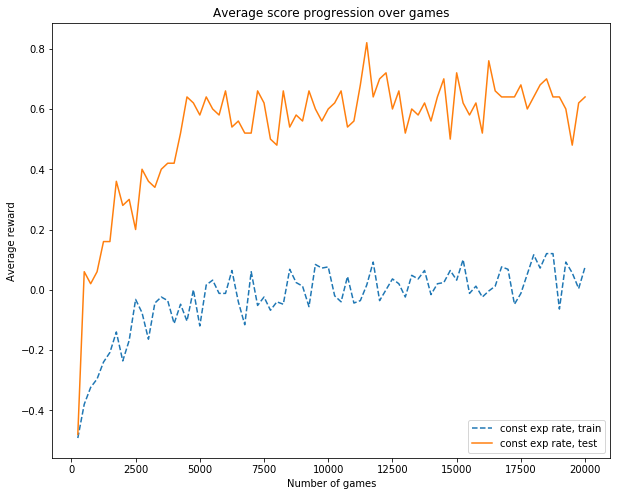

In [18]:
plt.plot((np.arange(len(train))+1)*250, train, '--', label='const exp rate, train')
plt.plot((np.arange(len(test))+1)*250, test, '-', label='const exp rate, test')    

plt.legend(loc="lower right")
plt.title('Average score progression over games')
plt.xlabel("Number of games")
plt.ylabel("Average reward")
plt.show()

The used exploration rate is $\epsilon=0.5$ because it should half of games explore and half of games agent plays best strategy

###  Decreasing exploration

One way to make training more efficient is to decrease the exploration level $\epsilon$ over time. If we define $\epsilon(n)$ to be $\epsilon$ for game number $n$, then one feasible way to decrease exploration during training is to use

$$
\epsilon(n)=\max \left\{\epsilon_{\min }, \epsilon_{\max }\left(1-\frac{n}{n^{*}}\right)\right\}
$$

where $\epsilon_{\min }$ and $\epsilon_{\max }$ are the minimum and maximum values for $\epsilon$, respectively, and $n^{*}$ is the number of exploratory games and shows how fast $\epsilon$ decreases. For convenience, we assume $\epsilon_{\min }=0.1$ and $\epsilon_{\max }=0.8$; if you are curious, you can explore their effect on performance for yourself. Use $\epsilon(n)$ as define above and run different Q-learning agents with different values of $n^{*}$ against Opt (0.5) for $20^{\prime} 000$ games - switch the 1 st player after every game. Choose several values of $n^{*}$ from a reasonably wide interval between 1 to $40^{\prime} 000-$ particularly, include $n^{*}=1$.

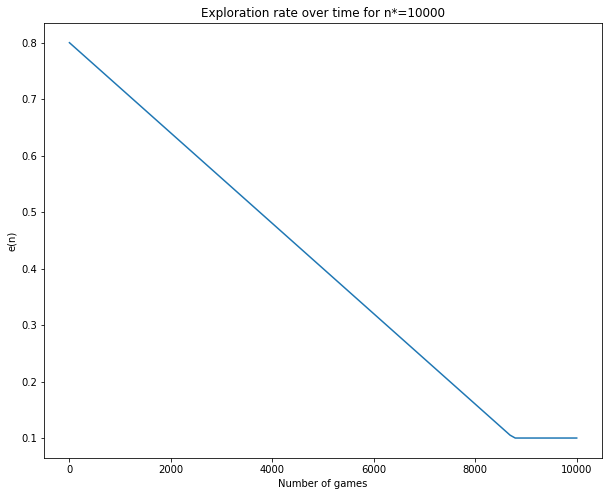

In [152]:
eps_min, eps_max = 0.1, 0.8
e = lambda n, n_star: max(eps_min, eps_max*(1 - n/n_star))

n_stars = np.linspace(1, 40000, 5).astype(int); n_stars

# Eps visualization
x = np.linspace(0, 10000, 100)
plt.plot(x, np.array([e(xi, 10000) for xi in x]))
plt.title('Exploration rate over time for n*=10000')
plt.xlabel("Number of games")
plt.ylabel("e(n)")
plt.show()

**Question 2**. Plot average reward for every 250 games during training. Does decreasing $\epsilon$ help training
compared to having a fixed $\epsilon$? What is the effect of $\textit n^∗$? \
*Expected answer*: A figure showing average reward over time for different values of $\textit n^∗$ (caption length <
200 words).

**Question 3**. After every 250 games during training, compute the 'test' $M_{\text {opt }}$ and $M_{\text {rand }}$ for your agents - when measuring the 'test' performance, put $\epsilon=0$ and do not update the $Q$-values. Plot $M_{\text {opt }}$ and $M_{\text {rand }}$ over time. Describe the differences and the similarities between these curves and the ones of the previous question. \
*Expected answer*: A figure showing $M_{\mathrm{opt}}$ and $M_{\text {rand }}$ over time for different values of $n^{*}$ (caption length $<100$ words). 


In [36]:
# It is antipattern to use global variables in functions, but now it's the easiest way to run functions in parallel
learning_rate = 0.05
discount_factor = 0.99
my_exp_rate = 0.5
opponent_eps = 0.5

printing = False
avg_every = 50
m = 5
N = 20000

def get_averages_decr_expl(n_star):
    """
    Function does the same as previous, but for non-constant eps
    
    """
    player = Player(learning_rate, discount_factor, my_exp_rate)
    
    train = []
    mopt = []
    mrand = []
    for i in range(avg_every*m, N+1, avg_every*m):
        batch = [
            player.train(avg_every, opponent_eps, e(i, n_star))
            for __ in range(0, m)
        ]
        train.append(sum(batch) / len(batch))
        
        mopt.append(player.test(avg_every, 0, 0))
        mrand.append(player.test(avg_every, 1, 0))
        
        if printing:
            print(f"Ep: {i}, test n*={n_star}: {round(test[-1], 3)}")

    del player
    return {'train': train, 'mopt': mopt, 'mrand': mrand}

In [37]:
results = to_parallel(get_averages_decr_expl, n_stars)

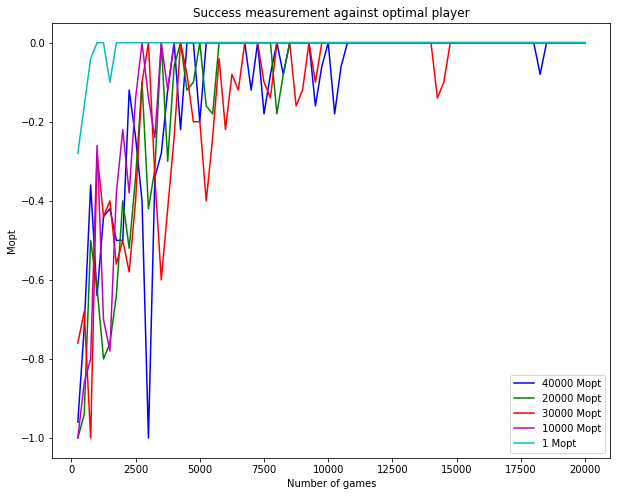

In [39]:
x_test = (np.arange(len(test))+1)*250
colors = 'bgrmc'
for i, n in enumerate(results):
    plt.plot(x_train, results[n]['mopt'], colors[i]+'-', label=f"{n} Mopt")

plt.legend(loc="lower right")
plt.title('Success measurement against optimal player')
plt.xlabel("Number of games")
plt.ylabel("Mopt")
plt.show()

Train results:
- eps = const — slowest learning, not the best results
- n* = 1 learns fast, not the best at the end
- n* = 10k learns slower, but has results better that n* = 1 and one of the best models
- n* = 20k constant growing and best results at the end
- n* = 30k learns slower, results aren't the best
- n* = 40k worst model so far, slowest learning 


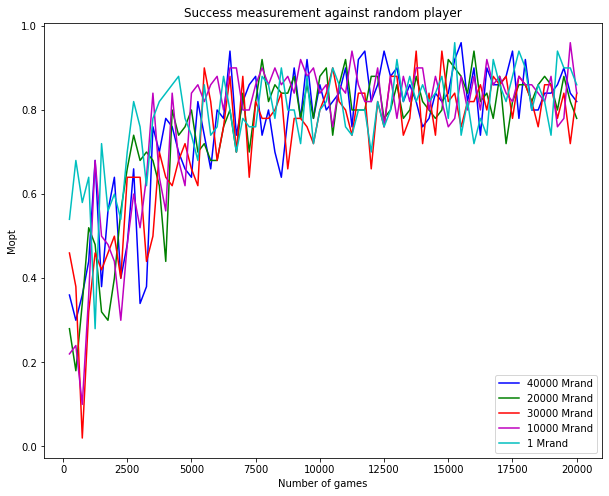

In [40]:
x_test = (np.arange(len(test))+1)*250
colors = 'bgrmc'
for i, n in enumerate(results):
    plt.plot(x_train, results[n]['mrand'], colors[i]+'-', label=f"{n} Mrand")

plt.legend(loc="lower right")
plt.title('Success measurement against random player')
plt.xlabel("Number of games")
plt.ylabel("Mrand")
plt.show()

Test results
- No matter the $n^*$, exploitation moves are pretty the same

#  Good experts and bad experts

Choose the best value of $n^{*}$ that you found in the previous section. Run $Q$-learning against Opt ( $\epsilon_{\text {opt }}$ ) for different values of $\epsilon_{\mathrm{opt}}$ for $20^{\prime} 000$ games - switch the 1st player after every game. Choose several values of $\epsilon_{\mathrm{opt}}$ from a reasonably wide interval between 0 to $1-$ particularly, include $\epsilon_{\mathrm{opt}}=0$.

In [41]:
epsilons = np.linspace(0, 1, 5)
print(epsilonslons)

n_star = 1

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [42]:
# It is antipattern to use global variables in functions, but now it's the easiest way to run functions in parallel
learning_rate = 0.05
discount_factor = 0.99
n_star = 1

printing = False
avg_every = 50
m = 5
N = 20000

def get_averages_gb_experts(opponent_eps):
    """
    Function does the same as previous, but for non-constant eps
    
    """
    player = Player(learning_rate, discount_factor, my_exp_rate)
    
    train = []
    mopt = []
    mrand = []
    for i in range(avg_every*m, N+1, avg_every*m):
        batch = [
            player.train(avg_every, opponent_eps, e(i, n_star))
            for __ in range(0, m)
        ]
        train.append(sum(batch) / len(batch))
        
        mopt.append(player.test(avg_every, 0, 0))
        mrand.append(player.test(avg_every, 1, 0))
        
        if printing:
            print(f"Ep: {i}, test n*={n_star}: {round(test[-1], 3)}")

    del player
    return {'train': train, 'mopt': mopt, 'mrand': mrand}

In [43]:
results = to_parallel(get_averages_gb_experts, epsilons)

**Question 4**. After every 250 games during training, compute the 'test' $M_{\text {opt }}$ and $M_{\text {rand }}$ for your agents - for each value of $\epsilon_{\mathrm{opt}}$. Plot $M_{\mathrm{opt}}$ and $M_{\text {rand }}$ over time. What do you observe? How can you explain it? Expected answer: A figure showing $M_{\mathrm{opt}}$ and $M_{\text {rand }}$ over time for different values of $\epsilon_{\mathrm{opt}}$ (caption length < 250 words).

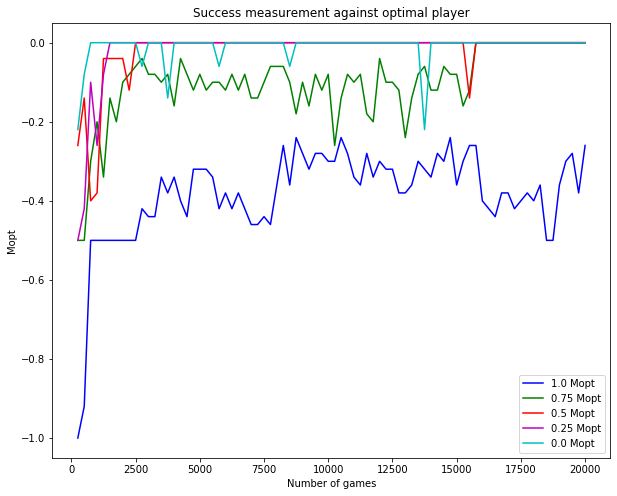

In [44]:
x_test = (np.arange(len(test))+1)*250
colors = 'bgrmc'
for i, n in enumerate(results):
    plt.plot(x_train, results[n]['mopt'], colors[i]+'-', label=f"{n} Mopt")

plt.legend(loc="lower right")
plt.title('Success measurement against optimal player')
plt.xlabel("Number of games")
plt.ylabel("Mopt")
plt.show()

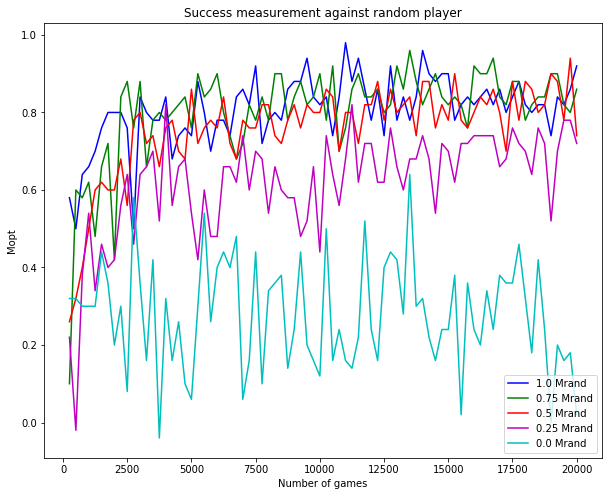

In [45]:
x_test = (np.arange(len(test))+1)*250
colors = 'bgrmc'
for i, n in enumerate(results):
    plt.plot(x_train, results[n]['mrand'], colors[i]+'-', label=f"{n} Mrand")

plt.legend(loc="lower right")
plt.title('Success measurement against random player')
plt.xlabel("Number of games")
plt.ylabel("Mrand")
plt.show()

**Question 5**. What are the highest values of $M_{\mathrm{opt}}$ and $M_{\text {rand }}$ that you could achieve after playing 20 '000 games?

In [65]:
print("Eps  Mrand Mopt")
for eps in results:
    print(f"{str(eps).ljust(4)} {max(results[eps]['mrand'])}  {max(results[eps]['mopt'])}")

Eps  Mrand Mopt
1.0  0.98  -0.24
0.75 0.96  0.0
0.5  0.94  0.0
0.25 0.82  0.0
0.0  0.64  0.0


**Question 6**. (Theory) Assume that Agent 1 learns by playing against Opt ( 0 ) and find the optimal Qvalues $Q_{1}(s, a)$. In addition, assume that Agent 2 learns by playing against Opt (1) and find the optimal $Q$-values $Q_{2}(s, a)$. Do $Q_{1}(s, a)$ and $Q_{2}(s, a)$ have the same values? Justify your answer. (answer length $<150$ words)

No. In \infty episodes even it doesn't work like this. Ant algo. It may work if personal eps is 0 and 1(against 1 and 0)

##  Learning by self-practice

In this section, your are supposed to ask whether Q-learning can learn to play Tic Tac Toe by only playing against itself. For different values of $\epsilon \in[0,1)$, run a $Q$-learning agent against itself for 20 '000 games - i.e. both players use the same set of $Q$-values and update the same set of $Q$-values.

**Question 7**. After every 250 games during training, compute the 'test' $M_{\mathrm{opt}}$ and $M_{\text {rand }}$ for different values of $\epsilon \in[0,1)$. Does the agent learn to play Tic Tac Toe? What is the effect of $\epsilon$ ? \
*Expected answer*: A figure showing $M_{\text {opt }}$ and $M_{\text {rand}}$ over time for different values of $\epsilon \in[0,1)$ (caption length $<100$ words).


In [138]:
epsilons = [0, 0.25, 0.5, 0.75, 0.99]

In [141]:
# It is antipattern to use global variables in functions, but now it's the easiest way to run functions in parallel
learning_rate = 0.05
discount_factor = 0.99

printing = False
avg_every = 50
m = 5
N = 20000

def get_averages_self_learning(eps):
    """
    Function does the same as previous, but for non-constant eps
    
    """
    player = Player(learning_rate, discount_factor, eps)
    
    train = []
    mopt = []
    mrand = []
    for i in range(avg_every*m, N+1, avg_every*m):
        batch = [
            player.train(avg_every, eps, eps, 1)
            for __ in range(0, m)
        ]
        train.append(sum(batch) / len(batch))
        
        mopt.append(player.test(avg_every, 0, 0, 1))
        mrand.append(player.test(avg_every, 1, 0, 1))
        
        if printing:
            print(f"Ep: {i}, test n*={n_star}: {round(test[-1], 3)}")

    del player
    return {'train': train, 'mopt': mopt, 'mrand': mrand}

In [142]:
results = to_parallel(get_averages_self_learning, epsilons)

Interesting explaination of exp_rate=1

Interesting explaination of (0,0),(0,1),(1,0),(1,1)

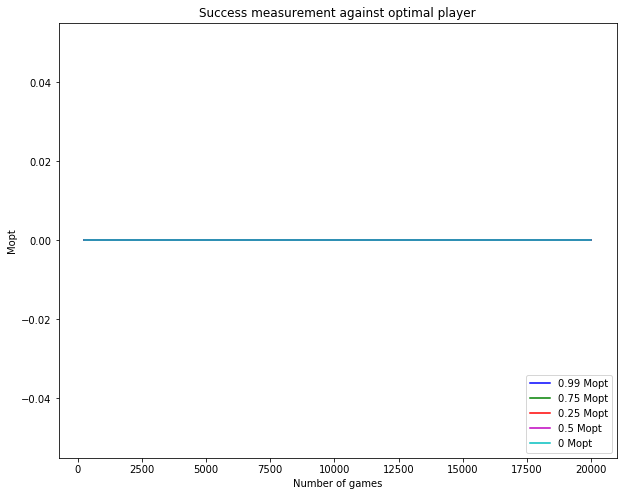

In [146]:
x_train = (np.arange(len(results[n]['train']))+1)*250
colors = 'bgrmc'
for i, n in enumerate(results):
    plt.plot(x_test, results[n]['mopt'], colors[i]+'-', label=f"{n} Mopt")

plt.legend(loc="lower right")
plt.title('Success measurement against optimal player')
plt.xlabel("Number of games")
plt.ylabel("Mopt")
plt.show()

Interesting explaination...

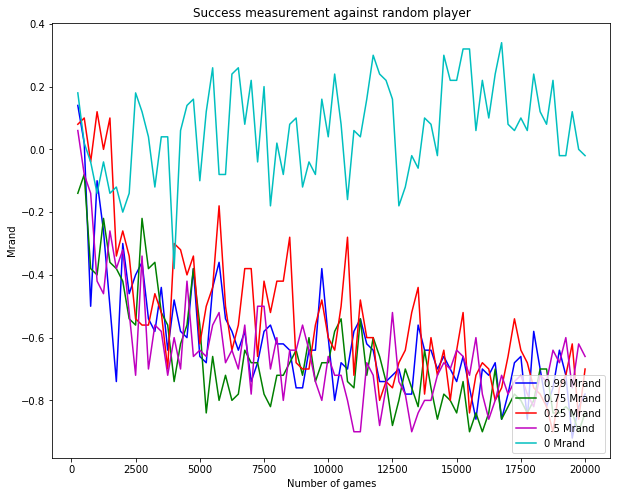

In [147]:
x_test = (np.arange(len(test))+1)*250
colors = 'bgrmc'
for i, n in enumerate(results):
    plt.plot(x_train, results[n]['mrand'], colors[i]+'-', label=f"{n} Mrand")

plt.legend(loc="lower right")
plt.title('Success measurement against random player')
plt.xlabel("Number of games")
plt.ylabel("Mrand")
plt.show()

Interesting explaination...

For rest of this section, use $\epsilon(n)$ in Equation 1 with different values of $n^{*}-$ instead of fixing $\epsilon$.

**Question 8**. After every 250 games during training, compute the 'test' $M_{\text {opt }}$ and $M_{\text {rand }}$ for your agents. Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$ ? What is the effect of $n^{*}$ ?\
*Expected answer*: A figure showing $M_{\mathrm{opt}}$ and $M_{\text {rand }}$ over time for different values of speeds of $n^{*}$ (caption length $<100$ words) .



In [148]:
n_stars = np.linspace(1, 40000, 5).astype(int); print(n_stars)

[    1 10000 20000 30000 40000]


In [155]:
# It is antipattern to use global variables in functions, but now it's the easiest way to run functions in parallel
learning_rate = 0.05
discount_factor = 0.99
my_exp_rate = 0.5

printing = False
avg_every = 50
m = 5
N = 20000

def get_averages_self_learning_decr_exp(n_star):
    """
    Function does the same as previous, but for non-constant eps
    
    """
    player = Player(learning_rate, discount_factor, my_exp_rate)
    
    train = []
    mopt = []
    mrand = []
    for i in range(avg_every*m, N+1, avg_every*m):
        batch = [
            player.train(avg_every, e(i, n_star), e(i, n_star), 1)
            for __ in range(0, m)
        ]
        train.append(sum(batch) / len(batch))
        
        mopt.append(player.test(avg_every, 0, 0, 1))
        mrand.append(player.test(avg_every, 1, 0, 1))
        
        if printing:
            print(f"Ep: {i}, test n*={n_star}: {round(test[-1], 3)}")

    del player
    return {'train': train, 'mopt': mopt, 'mrand': mrand}

In [156]:
results = to_parallel(get_averages_self_learning_decr_exp, n_stars)

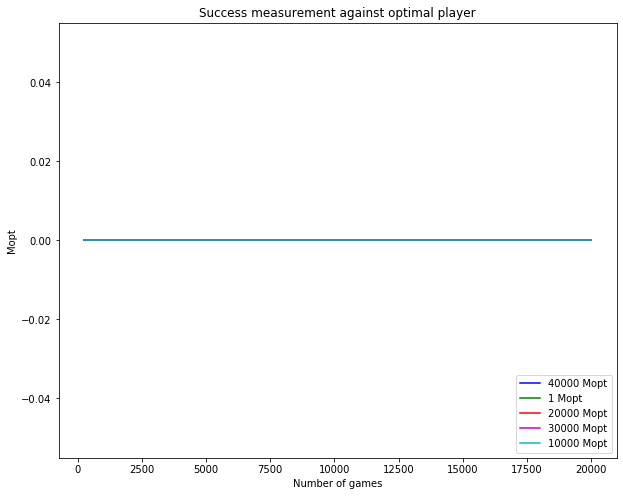

In [161]:
x_train = (np.arange(len(results[1]['train']))+1)*250
colors = 'bgrmc'
for i, n in enumerate(results):
    plt.plot(x_test, results[n]['mopt'], colors[i]+'-', label=f"{n} Mopt")

plt.legend(loc="lower right")
plt.title('Success measurement against optimal player')
plt.xlabel("Number of games")
plt.ylabel("Mopt")
plt.show()

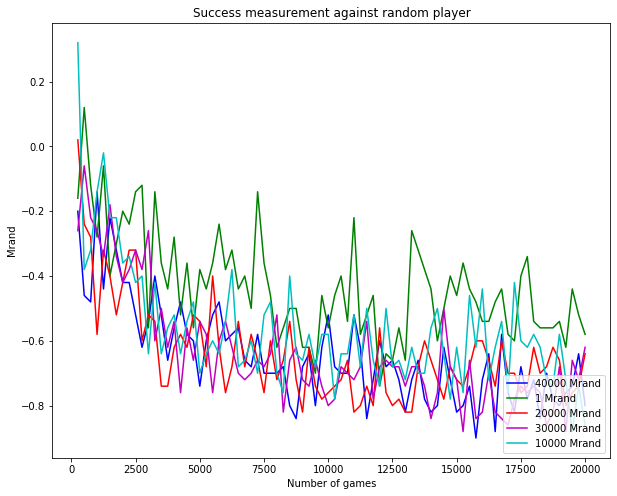

In [162]:
x_train = (np.arange(len(results[1]['train']))+1)*250
colors = 'bgrmc'
for i, n in enumerate(results):
    plt.plot(x_train, results[n]['mrand'], colors[i]+'-', label=f"{n} Mrand")

plt.legend(loc="lower right")
plt.title('Success measurement against random player')
plt.xlabel("Number of games")
plt.ylabel("Mrand")
plt.show()

**Question 9**. What are the highest values of $M_{\mathrm{opt}}$ and $M_{\text {rand }}$ that you could achieve after playing 20 '000 games?



In [169]:
print("Eps   Mrand  Mopt")
for eps in results:
    print(f"{str(eps).ljust(5)} {str(max(results[eps]['mrand'])).rjust(5)}  {max(results[eps]['mopt'])}")

Eps   Mrand  Mopt
40000 -0.14  0.0
1      0.12  0.0
20000  0.02  0.0
30000 -0.06  0.0
10000  0.32  0.0


**Question 10**. For three board arrangements (i.e. states $s$ ), visualize Q-values of available actions (e.g. using heat maps). Does the result make sense? Did the agent learn the game well?\
*Expected answer*: A figure with 3 subplots of 3 different states with $Q$-values shown at available actions (caption length $<200$ words).

In [174]:
learning_rate = 0.05
discount_factor = 0.99
my_exp_rate = 1
opponent_exp_rate = 1

my_player = Player(learning_rate, discount_factor, my_exp_rate)
train_avg = my_player.train(20000, opponent_exp_rate, my_exp_rate, 1)

In [257]:
states = [random.choice(list(my_player.states_value.keys())) for _ in range(3)]; state=states[0]

In [304]:
st2int = lambda st: int(((st.flatten() + 1) * (3**np.arange(9))).sum())
int2st = lambda val: np.array(list(map(lambda x: int(x)-1, np.base_repr(val,base=3)[::-1]))).reshape(3,3)

In [302]:
print(state)
print(state % 3**np.arange(9) % 3)
print(st2int(state % 3**np.arange(9) % 3))

12934
[0 1 1 1 1 1 1 1 1]
19681


In [303]:
st2int(int2st(states[1])) == states[1]

ValueError: operands could not be broadcast together with shapes (9,) (8,) 

#  Deep Q-Learning

As our 2nd algorithm, we use Deep Q-Learning (DQN) combined with $\epsilon$-greedy policy. You can watch again Part 1 of Deep Reinforcement Learning Lecture 1 for an introduction to DQN and Part 1 of Deep Reinforcement Learning Lecture 2 (in particular slide 8 ) for more details. The idea in DQN is to approximate $Q$-values by a neural network instead of a look-up table as in Tabular $Q$-learning. For implementation, you can use ideas from the DQN tutorials of Keras and PyTorch. 


In [ ]:
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# from torchvision.datasets import MNIST
# from torchvision.transforms import ToTensor


# class DQLNN(nn.Module):
#     """ DQLNN, expects input shape (3, 3, 2) """
#     def __init__(self):
#         super(DQLNN, self).__init__()

#         self.fc1 = nn.Linear(3*3*2, 128)
#         self.fc2 = nn.Linear(128, 128)
#         self.fc3 = nn.Linear(128, 9)
        
#     def forward(self, x):
#         return self.fc3(F.relu(self.fc2(F.relu(self.fc1(x.flatten())))))
    
# model_dql = DQLNN()

In [ ]:
# Player reinitializing

## Learning from experts

Implement the DQN algorithm. To check the algorithm, run a DQN agent with a fixed and arbitrary $\epsilon \in[0,1)$ against Opt $(0.5)$ for $20^{\prime} 000$ games - switch the 1st player after every game.

**Question 11**. Plot average reward and average training loss for every 250 games during training. Does the loss decrease? Does the agent learn to play Tic Tac Toe?\
*Expected answer*: A figure with two subplots (caption length $<50$ words). Specify your choice of $\epsilon$.

**Question 12**. Repeat the training but without the replay buffer and with a batch size of 1 : At every step, update the network by using only the latest transition. What do you observe?\
*Expected answer*: A figure with two subplots showing average reward and average training loss during training (caption length $<50$ words).

Instead of fixing $\epsilon$, use $\epsilon(n)$ in Equation 1. For different values of $n^{*}$, run your DQN against Opt ( $0.5$ ) for 20'000 games - switch the 1st player after every game. Choose several values of $n^{*}$ from a reasonably wide interval between 1 to $40^{\prime} 000$ - particularly, include $n^{*}=1$.

**Question 13**. After every 250 games during training, compute the 'test' $M_{\text {opt }}$ and $M_{\text {rand }}$ for your agents. Plot $M_{\text {opt }}$ and $M_{\text {rand }}$ over time. Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$ ? What is the effect of $n^{*}$ ?\
*Expected answer*: A figure showing $M_{\mathrm{opt}}$ and $M_{\text {rand }}$ over time for different values of opt (caption length $<250$ words).

Choose the best value of $n^{*}$ that you found. Run DQN against Opt ( $\epsilon_{\mathrm{opt}}$ ) for different values of $\epsilon_{\mathrm{opt}}$ for 20 '000 games - switch the 1st player after every game. Choose several values of $\epsilon_{\text {opt }}$ from a reasonably wide interval between 0 to $1-$ particularly, include $\epsilon_{\mathrm{opt}}=0$.

**Question 14**. After every 250 games during training, compute the 'test' $M_{\text {opt }}$ and $M_{\text {rand }}$ for your agents - for each value of $\epsilon_{\mathrm{opt}}$. Plot $M_{\mathrm{opt}}$ and $M_{\text {rand }}$ over time. What do you observe? How can you explain it? Expected answer: A figure showing $M_{\mathrm{opt}}$ and $M_{\text {rand }}$ over time for different values of $\epsilon_{\mathrm{opt}}$ (caption length $<250$ words).

**Question 15**. What are the highest values of $M_{\mathrm{opt}}$ and $M_{\text {rand }}$ that you could achieve after playing 20 '000 games?

##      Learning by self-practice

For different values of $\epsilon \in[0,1)$, run a DQN agent against itself for 20 ' 000 games - i.e. both players use the same neural network and share the same replay buffer. Important note: For one player, you should

add states $s_t$ and $s_{t'}$ as `x_t` and `x_tp` to the replay buffer, but for the other player, you should first swap
the opponent positions (x_t $[:,:, 1]$ and $\left.x_{-} \operatorname{tp}[:,:, 1]\right)$ with the agent's own positions (x_t $[:,:, 0]$ and $\left.x_{-} \operatorname{tp}[:,:, 0]\right)$ and then add them to the replay buffer.

**Question 16**. After every 250 games during training, compute the 'test' $M_{\text {opt }}$ and $M_{\text {rand }}$ for different values of $\epsilon \in[0,1)$. Plot $M_{\mathrm{opt}}$ and $M_{\mathrm{rand}}$ over time. Does the agent learn to play Tic Tac Toe? What is the effect of $\epsilon$ ?\
*Expected answer*: A figure showing $M_{\mathrm{opt}}$ and $ M_{\text {rand}}$ over time for different values of $\epsilon \in[0,1)$ (caption length $<100$ words) .

Instead of fixing $\epsilon$, use $\epsilon(n)$ in Equation 1 with different values of $n^{*}$.

**Question 17**. After every 250 games during training, compute the 'test' $M_{\text {opt }}$ and $M_{\text {rand }}$ for your agents. Plot $M_{\text {opt }}$ and $M_{\text {rand }}$ over time. Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$ ? What is the effect of $n^{*}$ ?\
*Expected answer*: A figure showing $M_{\mathrm{opt}}$ and $M_{\text {rand }}$ over time for different values of speeds of $n^{*}$ (caption length $<100$ words) .

**Question 18**. What are the highest values of $M_{\mathrm{opt}}$ and $M_{\text {rand }}$ that you could achieve after playing 20 '000 games?

**Question 19**. For three board arrangements (i.e. states $s$ ), visualize $Q$-values of available actions (e.g. using heat maps). Does the result make sense? Did the agent learn the game well?\
*Expected answer*: A figure with 3 subplots of 3 different states with $Q$-values shown at available actions (caption length $<200$ words).

# Comparing Q-Learning with Deep Q-Learning

We define the training time $T_{\text {train }}$ as the number of games an algorithm needs to play in order to reach $80 \%$ of its final performance according to both $M_{\text {opt }}$ and $M_{\text {rand }}$.

**Question 20**. Include a table showing the best performance (the highest $M_{\text {opt }}$ and $M_{\text {rand }}$ ) of $Q$-Learning and DQN (both for learning from experts and for learning by self-practice) and their corresponding training time.\
*Expected answer*: A table showing 12 values.

**Question 21**. Compare your results for DQN and Q-Learning (answer length $<300$ words).